In [2]:
import json
import numpy as np
import lmfit
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from lmfit import Parameters, minimize, report_fit
import sys
import os

In [3]:
import matplotlib as mpl

# Set Helvetica font globally
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Helvetica']

# Optional: make sure fonts are updated
mpl.rcParams['pdf.fonttype'] = 42  # Avoids Type 3 fonts in PDF output
mpl.rcParams['ps.fonttype'] = 42

In [4]:
### NMR degradation data

temps = []
reps = []
kdeg_vals = []

for temp in [25, 30, 37, 45, 52, 60]:
    for rep in ['a', 'b']:
        if temp == 30 and rep =='b':
            continue
        # read json-like file /home/ekc5108/b1044/Computational_Output/EKC/EKC.01_SHAPE_standardization/EKC.01.058.XSB_training_DMS/nmr_dms_deg/52_a.sav
        with open(f'/Users/edricchoi/LucksLab Dropbox/LucksLab/Lucks_Lab_Papers/In_Progress/88_EKC_Probing_model/Manuscript/Data_elements/data/nmr_dms_deg/{temp}_{rep}.sav') as f:
            data = json.load(f)
        kdeg_val = 1 / data['params'][1][1]
        temps.append(temp)
        reps.append(rep)
        kdeg_vals.append(kdeg_val)

df_kdeg = pd.DataFrame({'temperature': temps, 'replicate': reps, 'kdeg': kdeg_vals})
df_kdeg['lnkdeg'] = np.log(df_kdeg['kdeg'])
df_kdeg['inv_temp'] = 1 / (df_kdeg['temperature'] + 273.15)

# linear fit to get curve
model = lmfit.models.LinearModel()
params = model.make_params()
deg_result = model.fit(df_kdeg['lnkdeg'], params, x=df_kdeg['inv_temp'])
#deg_result.plot(fig_kws={'figsize': (3, 3)})
#plt.show()

# get slope and intercept
slope = deg_result.params['slope'].value
intercept = deg_result.params['intercept'].value


In [5]:
def get_kdeg(temp, slope=slope, intercept=intercept):
    return np.exp(slope / (temp + 273.15) + intercept)

def fmod_model(x, log_kappa, log_kdeg, log_fmod_0):
    kappa = np.exp(log_kappa)
    kdeg = np.exp(log_kdeg)
    fmod_0 = np.exp(log_fmod_0)
    return 1 - np.exp(- (kappa) * (1 - np.exp(-kdeg * x))) + fmod_0

def free_fit(df, temp, global_kdeg = None):
    site_nt = df['site'].astype(str).values[0] + df['base'].values[0]
    x_data = df['reaction_time'] * df['treated']
    y_data = df['fmod_val']

    model = lmfit.Model(fmod_model)

    kdeg0 = get_kdeg(temp)
    kappa0 = -np.log(1 - y_data.max())
    fmod_00 = max(y_data.min(), 1e-6)  # Avoid log(0) errors
    
    params = model.make_params(
        log_kappa=np.log(kappa0), 
        log_kdeg=np.log(kdeg0), 
        log_fmod_0=np.log(fmod_00)
    )
    
    if global_kdeg is not None:
        # this value is log already
        params['log_kdeg'].set(value=global_kdeg, vary=False)

    # No constraints needed since we fit in log space
    result = model.fit(y_data, params, x=x_data)
    
    # # Remove outlier outside of 1.5σ and refit
    outlier = np.abs(result.residual) > 150 * np.std(result.residual)
    
    if sum(outlier) > 0:
        x_data = x_data[~outlier]
        y_data = y_data[~outlier]
    
        # Initial values = values from previous fit
        params = model.make_params(
            log_kappa=result.best_values['log_kappa'], 
            log_kdeg=result.best_values['log_kdeg'], 
            log_fmod_0=result.best_values['log_fmod_0']
        )
        
        result = model.fit(y_data, params, x=x_data)

    return result, site_nt, outlier

# Create parameters
def create_params(free_fit_results):
    fit_params = Parameters()

    log_kdeg_global = free_fit_results['log_kdeg'].mean()

    # iterrate rows of free_fit_results
    for i in range(len(free_fit_results)):
        row = free_fit_results.iloc[i]
        site = row['site'].astype(int)
        log_kappa = row['log_kappa']
        log_fmod_0 = row['log_fmod_0']
        
        fit_params.add(f'log_kappa_{i+1}', value = log_kappa)
        fit_params.add(f'log_kdeg_{i+1}', value = log_kdeg_global)
        fit_params.add(f'log_fmod0_{i+1}', value = log_fmod_0)

        if i > 0:
            fit_params[f'log_kdeg_{i+1}'].expr = f'log_kdeg_1'
    return fit_params

# Create dataset
def create_dataset(free_fit_results, rg_df):
    sites = free_fit_results['site']
    data = []
    x_data = None
    for site in sites:
        site_df = rg_df[rg_df['site'] == site].copy()
        site_df['reaction_time'] = site_df['reaction_time'] * site_df['treated']
        site_df = site_df.sort_values(['site', 'reaction_time'])

        x_data = site_df['reaction_time']
        y_data = site_df['fmod_val']
        data.append(y_data)
    return x_data, np.array(data)

# Define the dataset function using log-transformed parameters
def fmod_dataset(params, i, x):
    """Calculate fmod from parameters for data set."""
    log_kappa = params[f'log_kappa_{i+1}']
    log_kdeg = params[f'log_kdeg_{i+1}']
    log_fmod0 = params[f'log_fmod0_{i+1}']
    return fmod_model(x, log_kappa, log_kdeg, log_fmod0)

# Define the objective function
def objective(params, x, data):
    """Calculate total residual for fits of fmod_model to several data sets."""
    ndata, _ = data.shape
    resid = np.zeros_like(data)

    # make residual per data set
    for i in range(ndata):
        resid[i, :] = data[i, :] - fmod_dataset(params, i, x)

    # Flatten residuals to a 1D array for optimization
    return resid.flatten()

def calculate_global_kdeg(free_fits_results, rg_df):
    global_params = create_params(free_fits_results)
    x_data, y_dataset = create_dataset(free_fits_results, rg_df)

    # make sure each data point has a corresponding time point
    assert x_data.shape[0] == y_dataset.shape[1]

    try:
        out = minimize(objective, global_params, args=(x_data, y_dataset))
    except:
        print('Global fitting failed')
        return None
    return out.params['log_kdeg_1'].value


In [6]:
db_path = '/Users/edricchoi/LucksLab Dropbox/LucksLab/Lucks_Lab_Papers/In_Progress/88_EKC_Probing_model/Manuscript/Data_elements/data/new.db'

def representative_rg_id(db_path, construct = '4U_wt', temperature = 25, buffer = None):
    # Define the query to get fmod_val and reaction_time with a join between the necessary tables
    query = f"""
        SELECT DISTINCT rg.rg_id
        FROM reaction_groups rg
        JOIN probing_reactions pr ON rg.rxn_id = pr.id
        JOIN constructs c ON pr.construct_id = c.id
        JOIN sequencing_samples ss ON pr.s_id = ss.id
        JOIN sequencing_runs sr ON ss.seqrun_id = sr.id
        WHERE c.disp_name = '{construct}'
        AND pr.temperature = {temperature}
    """

    if 'p4p6' in construct:
        query += f" AND pr.buffer_id = {buffer}"

    # Import data into dataframe
    conn = sqlite3.connect(db_path)
    rg_ids = list(pd.read_sql(query, conn)['rg_id'])
    conn.close()

    rg_id_qc_manual_bad_rg = ['18', '19', '20', '120']
    rg_ids = list(set(rg_ids) - set(rg_id_qc_manual_bad_rg))
    # pick random 1 from list of rg_ids
    return np.random.choice(rg_ids, 1, replace=False)[0]

In [7]:
def rep_freefit(construct = '4U_wt', temperature = 25, site = 18, buffer = None, chosen_rg_id = None):
    # buffer only used for p4p6, 2 = NoMg, 3 = Mg

    db_path = '/Users/edricchoi/LucksLab Dropbox/LucksLab/Lucks_Lab_Papers/In_Progress/88_EKC_Probing_model/Manuscript/Data_elements/data/new.db'
    rsq_thres = 0.6

    rg_id = representative_rg_id(db_path, construct, temperature, buffer)

    if chosen_rg_id is not None:
        rg_id = chosen_rg_id

    print(f'┌── Representative reaction group ID: {rg_id}')
    print(f'│   ├── Construct: {construct}')
    print(f'│   ├── Temperature: {temperature}')
    print(f'│   ├── Buffer: {buffer}')
    print(f'│   ├── Site: {site}')
    # Load from file
    with open("/Users/edricchoi/LucksLab Dropbox/LucksLab/Lucks_Lab_Papers/In_Progress/88_EKC_Probing_model/Manuscript/Data_elements/02_representative_timecourses/rg_manual_qc_todrop.json", "r") as f:
        todrop_dict = json.load(f)

    if str(rg_id) in todrop_dict:
        reaction_time_to_drop = todrop_dict[str(rg_id)]
        print(f'    ⚠️  Reaction group {rg_id} is in the manual QC to drop list, dropping the following reaction times: {reaction_time_to_drop}')
    else:
        reaction_time_to_drop = []

        

    store_results = []
    resids_free = []

    # Define the query to get fmod_val and reaction_time with a join between the necessary tables
    query = f"""
        SELECT fv.fmod_val, pr.reaction_time, n.site, n.base, pr.treated, fv.read_depth, pr.RT, fv.valtype, pr.temperature, c.disp_name, rg.rg_id, pr.buffer_id, sr.id, pr.done_by
        FROM probing_reactions pr
        JOIN fmod_vals fv ON pr.id = fv.rxn_id
        JOIN nucleotides n ON fv.nt_id = n.id
        JOIN constructs c ON pr.construct_id = c.id
        JOIN sequencing_samples ss ON pr.s_id = ss.id
        JOIN reaction_groups rg ON rg.rxn_id = pr.id
        JOIN sequencing_runs sr on ss.seqrun_id = sr.id
        WHERE rg.rg_id = {rg_id}
        AND fv.fmod_val IS NOT NULL
    """
    # Import data into dataframe
    conn = sqlite3.connect(db_path)
    rg_df = pd.read_sql(query, conn)
    conn.close()
    # Filter RT == 'MRT' and valtype == 'modrate'
    rg_df = rg_df[(rg_df['RT'] == 'MRT') & (rg_df['valtype'] == 'modrate')]

    if rg_id == '2':
        rg_df = rg_df[rg_df['done_by'] == 'RB']
    if rg_id == '3':
        rg_df = rg_df[rg_df['done_by'] == 'EKC']
        # at time zero, only keep under 0.07

    rg_df['reaction_time'] = rg_df['reaction_time'] * rg_df['treated']
    rg_df = rg_df.sort_values(['site', 'reaction_time'])
    # Drop reaction_time_to_drop
    removed_df = rg_df[rg_df['reaction_time'].isin(reaction_time_to_drop)]
    rg_df = rg_df[~rg_df['reaction_time'].isin(reaction_time_to_drop)]


    ############################################################################################################
    # Free fits
    print(f'\n┌── Free fitting started for site {site}...')

    sites = rg_df['site'].unique()
    os.makedirs('./freefits', exist_ok=True)
    site_df = rg_df[rg_df['site'] == site].copy()
    base = site_df['base'].values[0]
    #print(site_df)
    temp = site_df['temperature'].values[0]

    # replace time 300 with 30
    #site_df.loc[:, 'reaction_time'] = site_df['reaction_time'].replace(300, 30)
    #print('r2', fit_result.rsquared)
    # makedir ./freefits
    
    try:
        if ('hiv' in construct) and (temperature == 25):
            site_df = site_df[site_df['treated'] == 1]


        fit_result, site_nt, outliers = free_fit(site_df, temp)

        fig, ax = plt.subplots(figsize = (3, 3))
        fit_result.plot_fit(ax = ax, data_kws = {'color': 'black'}, fit_kws = {'color': 'black'})
        ax.set_title(f'Model(No_fmod_0) - {rg_id} {site}')
        ax.set_xlabel('Time (s)')
        ax.set_ylabel(r'$f_{mod}$')
        plt.tight_layout()
        plt.savefig(f'./freefits/{rg_id}_{site_nt}.png')
        plt.close()

        if fit_result.rsquared > rsq_thres:
            store_results.append([site, base, fit_result.best_values['log_kappa'], fit_result.best_values['log_kdeg'], fit_result.best_values['log_fmod_0'], fit_result.rsquared])
            resids_free.append(fit_result.residual)
            print(f'│   ├── ✅ Free fit succeeded at site {site}, appended to store_results')
    except:
        print(f'│   ├── ❌ Free fit failed at site {site}')

    free_fits_results = pd.DataFrame(store_results, columns=['site', 'base', 'log_kappa', 'log_kdeg', 'log_fmod_0', 'r2'])
    if len(free_fits_results) == 0:
        print(f'└── ⚠️  No successful free fits, returning None.')
    else:
        print(f'└── 🎉 Free fitting complete! Results stored.')
    
    return fit_result

In [8]:
def plot_fit(fit_result, ax, label, color = None):
    x_data = fit_result.userkws['x']
    y_data = fit_result.data
    ax.scatter(x_data / 3600., y_data * 100., color = color)

    smoothed_x = np.linspace(0, x_data.max(), 500)
    #smoothed_x = np.linspace(0, 36000, 500)
    smoothed_y = fit_result.eval(x=smoothed_x)
    ax.plot(smoothed_x / 3600., smoothed_y * 100., label = label, color = color)

    return ax

┌── Representative reaction group ID: 80
│   ├── Construct: 4U_wt
│   ├── Temperature: 25
│   ├── Buffer: None
│   ├── Site: 18

┌── Free fitting started for site 18...
│   ├── ✅ Free fit succeeded at site 18, appended to store_results
└── 🎉 Free fitting complete! Results stored.
┌── Representative reaction group ID: 80
│   ├── Construct: 4U_wt
│   ├── Temperature: 25
│   ├── Buffer: None
│   ├── Site: 7

┌── Free fitting started for site 7...
│   ├── ✅ Free fit succeeded at site 7, appended to store_results
└── 🎉 Free fitting complete! Results stored.
┌── Representative reaction group ID: 80
│   ├── Construct: 4U_wt
│   ├── Temperature: 25
│   ├── Buffer: None
│   ├── Site: 22

┌── Free fitting started for site 22...
│   ├── ✅ Free fit succeeded at site 22, appended to store_results
└── 🎉 Free fitting complete! Results stored.
┌── Representative reaction group ID: 80
│   ├── Construct: 4U_wt
│   ├── Temperature: 25
│   ├── Buffer: None
│   ├── Site: 35

┌── Free fitting started for si

/var/folders/k7/k3x4cyj90rz6_py6pr8yth9m0000gn/T/ipykernel_64265/901733977.py:41: RuntimeWarning: invalid value encountered in log
  df_params['lin_collapse'] = df_params['deg_collapse'].apply(lambda arr: -np.log(1 - np.array(arr)))
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


│   ├── ✅ Free fit succeeded at site 16, appended to store_results
└── 🎉 Free fitting complete! Results stored.
┌── Representative reaction group ID: 80
│   ├── Construct: 4U_wt
│   ├── Temperature: 25
│   ├── Buffer: None
│   ├── Site: 26

┌── Free fitting started for site 26...
│   ├── ✅ Free fit succeeded at site 26, appended to store_results
└── 🎉 Free fitting complete! Results stored.
┌── Representative reaction group ID: 80
│   ├── Construct: 4U_wt
│   ├── Temperature: 25
│   ├── Buffer: None
│   ├── Site: 29

┌── Free fitting started for site 29...
│   ├── ✅ Free fit succeeded at site 29, appended to store_results
└── 🎉 Free fitting complete! Results stored.


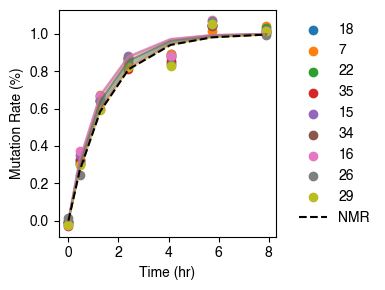

In [13]:
### all A's fourU

fig, ax = plt.subplots(figsize = (4, 3))


params = []
y_dats = []
x_dats = []
fmod0vals = []
kdegvals = []

sites = [18, 7, 22, 35, 15, 34, 16, 26, 29]

for site in sites:
    fourU_site = rep_freefit('4U_wt', 25, site, chosen_rg_id = 80)
    y_dat = fourU_site.data
    x_dat = fourU_site.userkws['x']

    params.append(fourU_site.params['log_kappa'].value)
    y_dats.append(y_dat)
    x_dats.append(x_dat)
    fmod0vals.append(fourU_site.params['log_fmod_0'].value)
    kdegvals.append(fourU_site.params['log_kdeg'].value)

# DataFrame for params
df_params = pd.DataFrame({
    'site': sites,
    'log_kappa': params,
    'y_data': y_dats,
    'x_data': x_dats,
    'log_fmod_0': fmod0vals,
    'log_kdeg': kdegvals
})

# operations
df_params['kappa'] = np.exp(df_params['log_kappa'])
df_params['y_data'] = df_params['y_data'] - df_params['log_fmod_0'].apply(np.exp)
df_params['ln_y'] = df_params['y_data'].apply(lambda arr: -np.log(1 - np.array(arr)))
df_params['deg_collapse'] = df_params['ln_y'] / df_params['kappa']
# Compute lin_collapse for each row (elementwise on lists)
df_params['lin_collapse'] = df_params['deg_collapse'].apply(lambda arr: -np.log(1 - np.array(arr)))

# old version
global_kdeg = np.exp(df_params['log_kdeg'].mean())

# new version
global_kdeg = get_kdeg(25)

for i, row in df_params.iterrows():
    #ax.scatter(row['x_data'], row['y_data'], label=f"Site {row['site']}", marker='o')

    # calculate fit using params
    kappa = row['kappa']
    kdeg = np.exp(row['log_kdeg'])
    kappa = np.exp(row['log_kappa'])
    ax.scatter(row['x_data'] / 3600., row['deg_collapse'], label=f"{row['site']}", marker='o')
    ax.plot(row['x_data'] / 3600., 1 - np.exp(-kdeg * row['x_data']), alpha = 0.5)

# plot global kdeg black
ax.plot(df_params['x_data'][0] / 3600., 1 - np.exp(-global_kdeg * df_params['x_data'][0]), color='black', label='NMR', linestyle='--')


ax.set_xlabel('Time (hr)')
ax.set_ylabel('Mutation Rate (%)')
ax.legend(frameon = False, loc = 'upper left', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.savefig('./4U_wt_allAs_25_representative_global_kdeg_collapse.pdf')
plt.show()

┌── Representative reaction group ID: 80
│   ├── Construct: 4U_wt
│   ├── Temperature: 25
│   ├── Buffer: None
│   ├── Site: 18

┌── Free fitting started for site 18...
│   ├── ✅ Free fit succeeded at site 18, appended to store_results
└── 🎉 Free fitting complete! Results stored.
┌── Representative reaction group ID: 80
│   ├── Construct: 4U_wt
│   ├── Temperature: 25
│   ├── Buffer: None
│   ├── Site: 7

┌── Free fitting started for site 7...
│   ├── ✅ Free fit succeeded at site 7, appended to store_results
└── 🎉 Free fitting complete! Results stored.
┌── Representative reaction group ID: 80
│   ├── Construct: 4U_wt
│   ├── Temperature: 25
│   ├── Buffer: None
│   ├── Site: 22

┌── Free fitting started for site 22...
│   ├── ✅ Free fit succeeded at site 22, appended to store_results
└── 🎉 Free fitting complete! Results stored.
┌── Representative reaction group ID: 80
│   ├── Construct: 4U_wt
│   ├── Temperature: 25
│   ├── Buffer: None
│   ├── Site: 35

┌── Free fitting started for si

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


│   ├── ✅ Free fit succeeded at site 26, appended to store_results
└── 🎉 Free fitting complete! Results stored.
┌── Representative reaction group ID: 80
│   ├── Construct: 4U_wt
│   ├── Temperature: 25
│   ├── Buffer: None
│   ├── Site: 29

┌── Free fitting started for site 29...
│   ├── ✅ Free fit succeeded at site 29, appended to store_results
└── 🎉 Free fitting complete! Results stored.


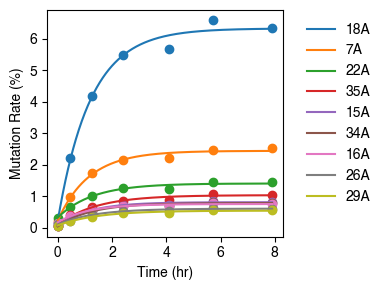

In [10]:
### all A's fourU

fig, ax = plt.subplots(figsize = (4, 3))

for site in [18, 7, 22, 35, 15, 34, 16, 26, 29]:
    fourU_site = rep_freefit('4U_wt', 25, site, chosen_rg_id = 80)
    plot_fit(fourU_site, ax, f'{site}A')

ax.set_xlabel('Time (hr)')
ax.set_ylabel('Mutation Rate (%)')
ax.legend(frameon = False, loc = 'upper left', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.savefig('./4U_wt_allAs_25_representative_fits.pdf')
plt.show()

┌── Representative reaction group ID: 22
│   ├── Construct: 4U_wt
│   ├── Temperature: 37
│   ├── Buffer: None
│   ├── Site: 18

┌── Free fitting started for site 18...
│   ├── ✅ Free fit succeeded at site 18, appended to store_results
└── 🎉 Free fitting complete! Results stored.
┌── Representative reaction group ID: 22
│   ├── Construct: 4U_wt
│   ├── Temperature: 37
│   ├── Buffer: None
│   ├── Site: 7

┌── Free fitting started for site 7...
│   ├── ✅ Free fit succeeded at site 7, appended to store_results
└── 🎉 Free fitting complete! Results stored.
┌── Representative reaction group ID: 22
│   ├── Construct: 4U_wt
│   ├── Temperature: 37
│   ├── Buffer: None
│   ├── Site: 22

┌── Free fitting started for site 22...
│   ├── ✅ Free fit succeeded at site 22, appended to store_results
└── 🎉 Free fitting complete! Results stored.
┌── Representative reaction group ID: 22
│   ├── Construct: 4U_wt
│   ├── Temperature: 37
│   ├── Buffer: None
│   ├── Site: 35

┌── Free fitting started for si

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp



┌── Free fitting started for site 26...
│   ├── ✅ Free fit succeeded at site 26, appended to store_results
└── 🎉 Free fitting complete! Results stored.
┌── Representative reaction group ID: 22
│   ├── Construct: 4U_wt
│   ├── Temperature: 37
│   ├── Buffer: None
│   ├── Site: 29

┌── Free fitting started for site 29...
│   ├── ✅ Free fit succeeded at site 29, appended to store_results
└── 🎉 Free fitting complete! Results stored.


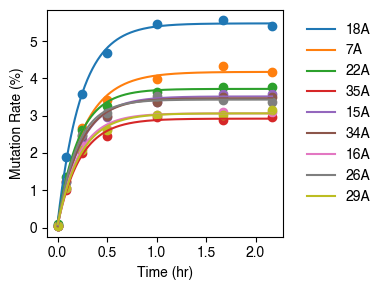

In [11]:
### all A's fourU

fig, ax = plt.subplots(figsize = (4, 3))

for site in [18, 7, 22, 35, 15, 34, 16, 26, 29]:
    fourU_site = rep_freefit('4U_wt', 37, site, chosen_rg_id = 22)
    plot_fit(fourU_site, ax, f'{site}A')

ax.set_xlabel('Time (hr)')
ax.set_ylabel('Mutation Rate (%)')
ax.legend(frameon = False, loc = 'upper left', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.savefig('./4U_wt_allAs_37_representative_fits.pdf')
plt.show()

┌── Representative reaction group ID: 17
│   ├── Construct: 4U_wt
│   ├── Temperature: 60
│   ├── Buffer: None
│   ├── Site: 18

┌── Free fitting started for site 18...
│   ├── ✅ Free fit succeeded at site 18, appended to store_results
└── 🎉 Free fitting complete! Results stored.
┌── Representative reaction group ID: 17
│   ├── Construct: 4U_wt
│   ├── Temperature: 60
│   ├── Buffer: None
│   ├── Site: 7

┌── Free fitting started for site 7...
│   ├── ✅ Free fit succeeded at site 7, appended to store_results
└── 🎉 Free fitting complete! Results stored.
┌── Representative reaction group ID: 17
│   ├── Construct: 4U_wt
│   ├── Temperature: 60
│   ├── Buffer: None
│   ├── Site: 22

┌── Free fitting started for site 22...
│   ├── ✅ Free fit succeeded at site 22, appended to store_results
└── 🎉 Free fitting complete! Results stored.
┌── Representative reaction group ID: 17
│   ├── Construct: 4U_wt
│   ├── Temperature: 60
│   ├── Buffer: None
│   ├── Site: 35

┌── Free fitting started for si

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


│   ├── ✅ Free fit succeeded at site 26, appended to store_results
└── 🎉 Free fitting complete! Results stored.
┌── Representative reaction group ID: 17
│   ├── Construct: 4U_wt
│   ├── Temperature: 60
│   ├── Buffer: None
│   ├── Site: 29

┌── Free fitting started for site 29...
│   ├── ✅ Free fit succeeded at site 29, appended to store_results
└── 🎉 Free fitting complete! Results stored.


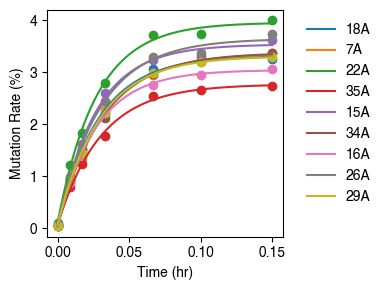

In [12]:
### all A's fourU

fig, ax = plt.subplots(figsize = (4, 3))

for site in [18, 7, 22, 35, 15, 34, 16, 26, 29]:
    fourU_site = rep_freefit('4U_wt', 60, site, chosen_rg_id = 17)
    plot_fit(fourU_site, ax, f'{site}A')

ax.set_xlabel('Time (hr)')
ax.set_ylabel('Mutation Rate (%)')
ax.legend(frameon = False, loc = 'upper left', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.savefig('./4U_wt_allAs_60_representative_fits.pdf')
plt.show()